## Лабортаторная работа №8

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств динамических сетей, алгоритмов обучения, а также применеие сетей в задачах аппроксимации функции и распознавания динамических образов 

In [1]:
import numpy as np
import pylab
import copy
import sklearn as skl
import csv
import collections as col

import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

### Обучающая функция и модели

In [110]:
def train(net,trainXX,trainLB,n_epochs,batch_size,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.MSELoss(),
         ):
    #функция, производящая обучение сети
    arr = []
    
    optim = optimiser(net.parameters(),lr=lr)
    
    num_batches = len(trainXX)/batch_size
    
    for i in tqdm(range(n_epochs)):
                
        for j in range(int(num_batches)):
            batchXX = trainXX[j*batch_size : (j+1)*batch_size]
            batchLB = trainLB[j*batch_size : (j+1)*batch_size]
            
            optim.zero_grad()
            loss = criterion(net(batchXX),batchLB)
            loss.backward()
            optim.step()
            
        #трэйсинг обучения
        arr.append([i,loss.detach().numpy()]) #среднее количество совпадений в предсказаниях (точность)
                    
    return np.array(arr)

def plot_learning(arr):
    pylab.grid()
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("loss",color = "grey")
    pylab.plot(arr[:,0],arr[:,1])
    pylab.show()

In [98]:
class TDL(torch.nn.Module):
    def __init__(self,feat_cnt,ent_cnt = 1):
        super(TDL,self).__init__()
        self.feat_cnt = feat_cnt
        self.ent_cnt = ent_cnt
        self.line = col.deque()
        self.clear()
        
    def clear(self):
        self.line.clear()
        for i in range(self.ent_cnt):
            self.line.append(torch.zeros(self.feat_cnt))
            
    def push(self,input):
        self.line.appendleft(input)
        
    def forward(self):
        return self.line.pop()
            

In [148]:
class DynamicModule(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size,banks_size = 3):
        super(DynamicModule,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.act_func = torch.nn.Tanh()
        
        self.wts_prime = torch.nn.Parameter(torch.randn(input_size,hidden_size)) #w1
        self.wts_shift = torch.nn.Parameter(torch.randn(hidden_size)) #b1
        
        self.wts_pass = torch.nn.Parameter(torch.randn(hidden_size,output_size)) #w2
        self.wts_pass_shift = torch.nn.Parameter(torch.randn(output_size)) #b2
        
        self.wts_reinp = torch.nn.Parameter(torch.randn(output_size,hidden_size)) #w3
        
        self.inp_bank = TDL(input_size,banks_size)
        
        self.inp_bank.clear()
        
        self.reinp_bank = TDL(output_size,banks_size)
        
        self.reinp_bank.clear()
        
    def clear(self):
        self.inp_bank.clear()
        self.reinp_bank.clear()
        
        
    def forward(self,input):
        
        self.inp_bank.push(input)
        
        hidden = self.inp_bank.forward() @ self.wts_prime + self.wts_shift
        hidden += self.reinp_bank.forward() @ self.wts_reinp
        
        passed = self.act_func(hidden)
        passed = passed @ self.wts_pass + self.wts_pass_shift
        
        res = passed
        
        self.reinp_bank.push(torch.nn.Parameter(res))
        
        return res

### Сгенерированные данные

In [198]:
N,w = 600,5
t = np.linspace(0,5,N)
uk,yk = np.sin(t**2 - 10*t + 3),[0]

for i in range(N-1):
    yk += [yk[-1] / (1 + yk[-1]**2) + uk[i]]
    
train_data = np.array(([(np.array(uk[i:i+w],dtype = np.float32), #точки чистой функции
               np.array(yk[i:i+w],dtype = np.float32)) for i in range(N-5)])) #точки искаженной функции

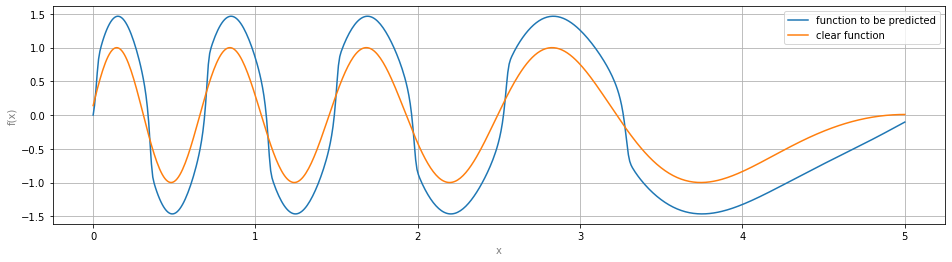

In [199]:
pylab.figure(figsize = (16,4))
pylab.xlabel("x",color = "grey")
pylab.ylabel("f(x)",color = "grey")
pylab.grid()
pylab.plot(t,yk,label = "function to be predicted")
pylab.plot(t,uk,label = "clear function")
pylab.legend()
pylab.show()

### Обучение и тестирование

In [206]:
bs = 1
lr = 0.01

dn = DynamicModule(5,10,5)

dn.clear()
dn.train()
arr = train(dn,torch.tensor(train_data[:,0]),torch.tensor(train_data[:,1]),400,bs,lr)
dn.clear()
dn.eval()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:57<00:00,  2.25it/s]


DynamicModule(
  (act_func): Tanh()
  (inp_bank): TDL()
  (reinp_bank): TDL()
)

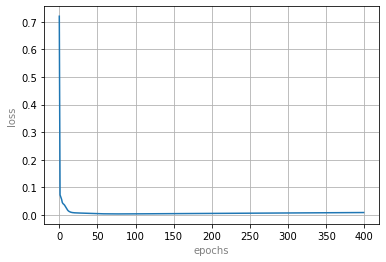

In [207]:
plot_learning(arr)

In [208]:
dn.clear()
dn.eval()

res = dn(torch.tensor(train_data[:,0])[0]).detach().numpy()[0:w].tolist()
for elm in torch.tensor(train_data[:,0]):
    res += [dn(elm).detach().numpy()[w-1]]

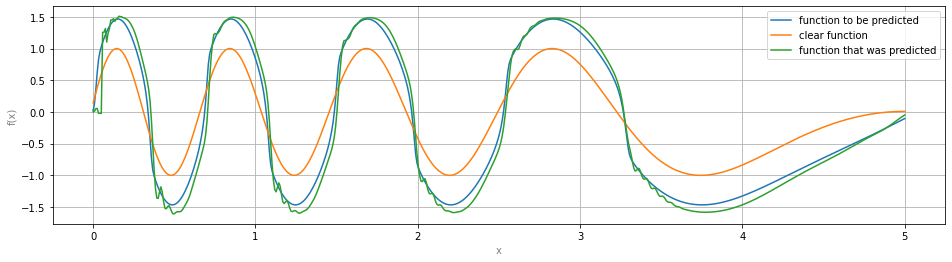

In [209]:
pylab.figure(figsize = (16,4))
pylab.xlabel("x",color = "grey")
pylab.ylabel("f(x)",color = "grey")
pylab.grid()
pylab.plot(t,yk,label = "function to be predicted")
pylab.plot(t,uk,label = "clear function")
pylab.plot(t,res,label = "function that was predicted")
pylab.legend()
pylab.show()

### Вывод

В ходе выполнения этой лабораторной работы я ознакомился с принципами работы динамических сетей и освоил их применение в распозновании функций.